In [29]:
import os
import sys
import shutil
import pickle

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage import img_as_ubyte

from keras.models import Model, load_model, Sequential, model_from_json
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda, Flatten, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras import optimizers

import imgaug as ia
from imgaug import augmenters as iaa

sys.path.append(r'C:\Users\nimro\Documents\Python Scripts')
import img_utils

%matplotlib inline

# Paths and Constants

In [2]:
# Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
VAL_SPLIT = 0.15
ANNOTATED_SIZE = 400
VAL_SIZE = int(ANNOTATED_SIZE * VAL_SPLIT) + 1 # to match sklearn train_test_split function with sizes
TRAIN_SIZE = ANNOTATED_SIZE - VAL_SIZE
# Paths
TRAIN_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\boneage-training-dataset'
MASK_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\masks'
TEST_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\boneage-test-dataset'
REG_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\reg'
SEG_PATH = r'C:\Users\nimro\Documents\Data\rsna_bone_age\seg'

In [ ]:
count_ = 0
for n, file in enumerate(os.listdir(REG_PATH)):
    full_path = os.path.join(TRAIN_PATH, file)
    if os.path.isfile(full_path):
        os.remove(os.path.join(TRAIN_PATH, file))
    else:
        count_+=1

print(count_)

for f in random_filenames:
    if np.isin(f, os.path.join(REG_PATH)):
        print(f)

# Arrays decleration

In [3]:
train_filenames = os.listdir(TRAIN_PATH)
random_filenames = np.random.choice(train_filenames, ANNOTATED_SIZE, replace=False)
Y_train = np.zeros((ANNOTATED_SIZE, 6), dtype=np.float32)
X_regs = np.zeros((ANNOTATED_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
X_train = np.zeros((ANNOTATED_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_names = np.zeros(ANNOTATED_SIZE, dtype=np.int32)
X_train_after_split = np.zeros((TRAIN_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train_after_split = np.zeros((TRAIN_SIZE, 6), dtype=np.float32)
X_val = np.zeros((VAL_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_val = np.zeros((VAL_SIZE, 6), dtype=np.float32)
X_masks = np.zeros((ANNOTATED_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Image Annotation Phase

In [ ]:
"""Annotation phase"""
thumb_coordinates = []
middle_finger_coordinates = []
base_coordinates = []
count = 0

def click_and_mark(event, x, y, flags, params):
    global thumb_coordinates, middle_finger_coordinates, base_coordinates
    global count
    if event == cv2.EVENT_LBUTTONDBLCLK: 
        if count % 3 == 0:
            thumb_coordinates.append((x,y))                                        
        elif count % 3 == 1:
            middle_finger_coordinates.append((x,y))                
        elif count % 3 == 2:
            base_coordinates.append((x,y))
                
        count+=1
                
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_mark)

for n, img_ in enumerate(random_filenames):    
    print('Iteration #' + str(n))
    fullPath = os.path.join(TRAIN_PATH, img_)
    img = np.expand_dims(imread(fullPath)[:,:], axis=2)    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
    img /= 255
    img_clone = img.copy()
    X_train[n, :, : , :] = img
    shutil.copy(fullPath, os.path.join(REG_PATH,img_))
    
    #annotate 3 locations
    thumb_coordinates = []
    middle_finger_coordinates = []
    base_coordinates = []
    while True:
        # display the image and wait for a keypress
        cv2.imshow("image", img)
        key = cv2.waitKey(1) & 0xFF 
        # if the 'c' key is pressed, break from the loop
        if key == ord("c"):
            break                 
    try:  
        srcPts = np.concatenate([thumb_coordinates, middle_finger_coordinates, base_coordinates], axis=0).astype(np.float32)
        Y_train[n] = srcPts.reshape(6)        
        base, ext = os.path.splitext(img_)
        Y_names[n] = int(base)
        print(Y_names[n])
        print(Y_train[n])     
        
    except:
        print("error in calc transformation")
    
cv2.destroyAllWindows()
# save annotation to file
np.savetxt(os.path.join(REG_PATH,'train_coordinates.csv'), np.concatenate((np.expand_dims(Y_names,1),Y_train), axis=1), delimiter=',')

In [4]:
#load annotations from file
res = np.genfromtxt(os.path.join(REG_PATH,'train_coordinates.csv'), delimiter=',')
loaded_train_data = res[:,1:]

# CNN Model

In [96]:
"""Build CNN model for perform geometric transformation regression"""
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = Dropout(0.3)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
# x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
# x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(6)(x)

model = Model(inputs=[inputs], outputs=[outputs])
Optimizer = optimizers.adam()
model.compile(optimizer=Optimizer, loss='mean_squared_error', metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 128, 128, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
dropout_29 (Dropout)         (None, 128, 128, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
__________

# Pre-Process Phase

In [6]:
"""Train - Validation split"""
for n, annotate_img_ in enumerate (res[:,0].astype(np.int32).astype(np.str)):        
    filename = annotate_img_ + '.png'    
    fullPath = os.path.join(REG_PATH, filename)            
    current_img = np.expand_dims(imread(fullPath)[:,:], axis=2)    
    current_img = resize(current_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
    current_img /= 255     
    X_train[n] = current_img 
    
X_train_after_split, X_val, Y_train_after_split, Y_val = train_test_split(
    X_train, loaded_train_data, test_size=0.15, random_state=42)


Segmentation model loaded


C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


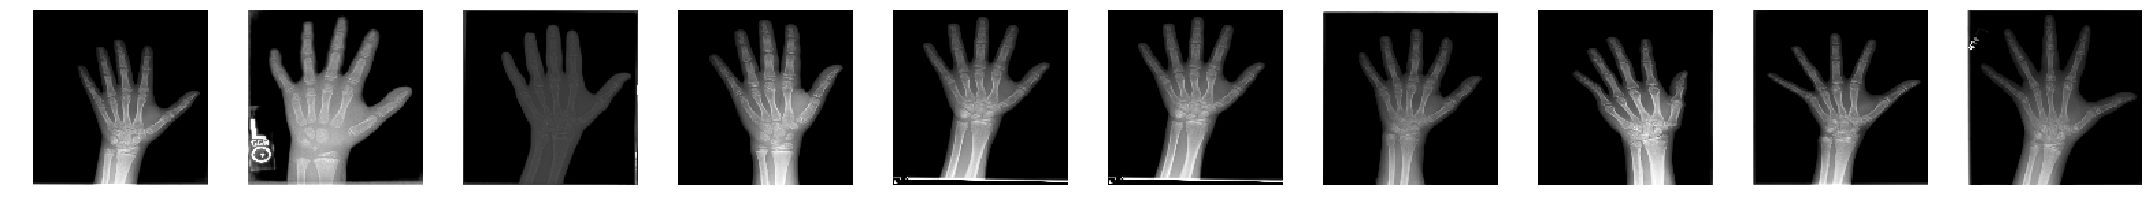

In [8]:
json_file = open('model_segmentation.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
segmentationModel = model_from_json(loaded_model_json)
# load weights into new model
segmentationModel.load_weights("model_segmentation_weights.h5")
print("Segmentation model loaded")

X_masks = segmentationModel.predict(img_as_ubyte(X_train_after_split))

X_train_after_split = X_train_after_split * X_masks

img_utils.showRandomDataFromArray(X_train_after_split)

Keypoint 0: (112.00000000, 45.00000000) -> (107.00000000, 35.00000000)
Keypoint 1: (60.00000000, 15.00000000) -> (49.00000000, 17.00000000)
Keypoint 2: (56.00000000, 113.00000000) -> (67.00000000, 113.00000000)


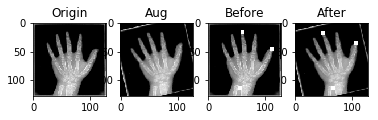

Keypoint 0: (117.00000000, 48.00000000) -> (117.00000000, 48.00000000)
Keypoint 1: (62.00000000, 7.00000000) -> (62.00000000, 7.00000000)
Keypoint 2: (59.00000000, 111.00000000) -> (59.00000000, 111.00000000)


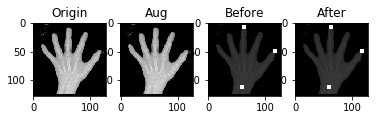

Keypoint 0: (111.00000000, 49.00000000) -> (77.00000000, 23.00000000)
Keypoint 1: (60.00000000, 11.00000000) -> (14.00000000, 21.00000000)
Keypoint 2: (59.00000000, 118.00000000) -> (74.00000000, 109.00000000)


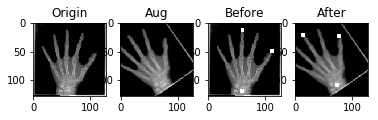

Keypoint 0: (114.00000000, 45.00000000) -> (113.00000000, 69.00000000)
Keypoint 1: (62.00000000, 10.00000000) -> (60.00000000, 36.00000000)
Keypoint 2: (52.00000000, 95.00000000) -> (53.00000000, 121.00000000)


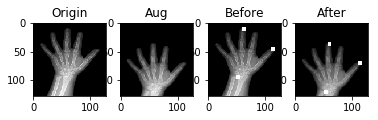

Keypoint 0: (112.00000000, 45.00000000) -> (104.00000000, 63.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (58.00000000, 17.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (37.00000000, 115.00000000)


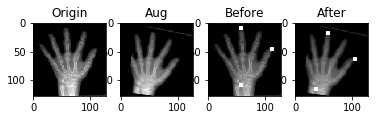

Keypoint 0: (118.00000000, 53.00000000) -> (104.00000000, 76.00000000)
Keypoint 1: (38.00000000, 9.00000000) -> (18.00000000, 108.00000000)
Keypoint 2: (59.00000000, 111.00000000) -> (54.00000000, 10.00000000)


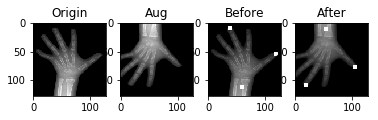

Keypoint 0: (122.00000000, 63.00000000) -> (122.00000000, 63.00000000)
Keypoint 1: (68.00000000, 27.00000000) -> (68.00000000, 27.00000000)
Keypoint 2: (56.00000000, 108.00000000) -> (56.00000000, 108.00000000)


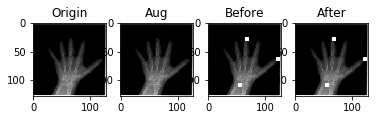

Keypoint 0: (116.00000000, 53.00000000) -> (115.00000000, 79.00000000)
Keypoint 1: (66.00000000, 8.00000000) -> (92.00000000, 16.00000000)
Keypoint 2: (58.00000000, 107.00000000) -> (38.00000000, 99.00000000)


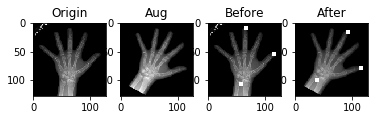

Keypoint 0: (118.00000000, 59.00000000) -> (118.00000000, 59.00000000)
Keypoint 1: (70.00000000, 15.00000000) -> (70.00000000, 15.00000000)
Keypoint 2: (46.00000000, 111.00000000) -> (46.00000000, 111.00000000)


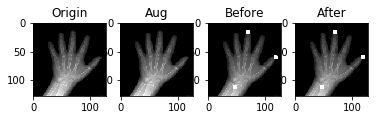

Keypoint 0: (68.00000000, 11.00000000) -> (68.00000000, 116.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (59.00000000, 28.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (112.00000000, 80.00000000)


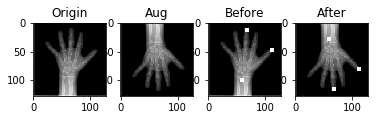

Keypoint 0: (95.00000000, 41.00000000) -> (82.00000000, 55.00000000)
Keypoint 1: (56.00000000, 13.00000000) -> (41.00000000, 29.00000000)
Keypoint 2: (51.00000000, 77.00000000) -> (39.00000000, 92.00000000)


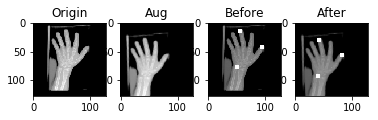

Keypoint 0: (118.00000000, 47.00000000) -> (104.00000000, 56.00000000)
Keypoint 1: (66.00000000, 5.00000000) -> (52.00000000, 14.00000000)
Keypoint 2: (55.00000000, 98.00000000) -> (41.00000000, 107.00000000)


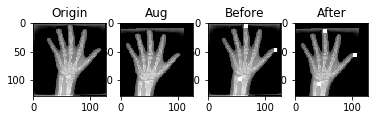

Keypoint 0: (116.00000000, 45.00000000) -> (104.00000000, 25.00000000)
Keypoint 1: (78.00000000, 12.00000000) -> (56.00000000, 11.00000000)
Keypoint 2: (61.00000000, 111.00000000) -> (80.00000000, 108.00000000)


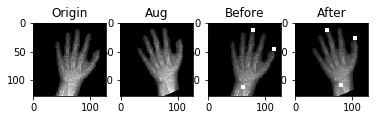

Keypoint 0: (122.00000000, 62.00000000) -> (122.00000000, 62.00000000)
Keypoint 1: (57.00000000, 11.00000000) -> (57.00000000, 11.00000000)
Keypoint 2: (51.00000000, 113.00000000) -> (51.00000000, 113.00000000)


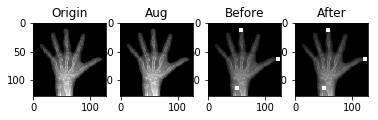

Keypoint 0: (112.00000000, 44.00000000) -> (112.00000000, 44.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (58.00000000, 6.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (56.00000000, 109.00000000)


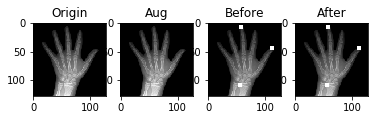

Keypoint 0: (118.00000000, 53.00000000) -> (116.00000000, 67.00000000)
Keypoint 1: (44.00000000, 23.00000000) -> (51.00000000, 19.00000000)
Keypoint 2: (66.00000000, 95.00000000) -> (55.00000000, 95.00000000)


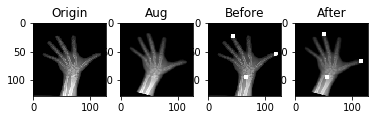

Keypoint 0: (118.00000000, 60.00000000) -> (118.00000000, 60.00000000)
Keypoint 1: (53.00000000, 3.00000000) -> (53.00000000, 3.00000000)
Keypoint 2: (56.00000000, 108.00000000) -> (56.00000000, 108.00000000)


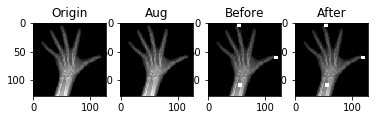

340


In [22]:
"""Data Augmentation"""
ia.seed(1)
augmented_imgs = np.zeros((len(X_train_after_split), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
augmented_labels = np.zeros((len(X_train_after_split), 6), dtype=np.float32)
border = 3

seq = iaa.Sequential(
[
    iaa.SomeOf((0,5),
   [
    iaa.Affine( translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)},
        rotate=(-10, 10),deterministic=True),
    iaa.Affine( translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)}, deterministic=True),
    iaa.Affine( rotate=(-30, 30), deterministic=True),
    iaa.Fliplr(0.25),
    iaa.Flipud(0.25)
   ])
], random_order=True)
k = 0
for n, annotate_img_ in enumerate (X_train_after_split):
    bSkip = True
    try:
        while bSkip == True:            
            current_img = X_train_after_split[n]
            keypoints = ia.KeypointsOnImage([
            ia.Keypoint(x=int(Y_train_after_split[n][0]), y=int(Y_train_after_split[n][1])),
            ia.Keypoint(x=int(Y_train_after_split[n][2]), y=int(Y_train_after_split[n][3])),
            ia.Keypoint(x=int(Y_train_after_split[n][4]), y=int(Y_train_after_split[n][5]))
            ], shape=current_img.shape)

            seq_det = seq.to_deterministic()
            image_aug = seq_det.augment_images([current_img])[0]
            keypoints_aug = seq_det.augment_keypoints([keypoints])[0]            
            bSkip = False
            if np.equal(keypoints, keypoints_aug):
                bSkip = True
            for j in range(3):
                if keypoints_aug.keypoints[j].x > (IMG_WIDTH-border) or keypoints_aug.keypoints[j].y > (IMG_HEIGHT-border):
                    bSkip = True
                if keypoints_aug.keypoints[j].x < 0 or keypoints_aug.keypoints[j].y < 0:
                    bSkip = True
                            
        augmented_imgs[k,:,:,:] = image_aug    
        augmented_labels[k,0] = keypoints_aug.keypoints[0].x
        augmented_labels[k,1] = keypoints_aug.keypoints[0].y
        augmented_labels[k,2] = keypoints_aug.keypoints[1].x
        augmented_labels[k,3] = keypoints_aug.keypoints[1].y
        augmented_labels[k,4] = keypoints_aug.keypoints[2].x
        augmented_labels[k,5] = keypoints_aug.keypoints[2].y
        k+=1
        if k % 20 == 0:
            for i in range(len(keypoints.keypoints)):
                before = keypoints.keypoints[i]
                after = keypoints_aug.keypoints[i]
                print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
                    i, before.x, before.y, after.x, after.y)
                )

            # image with keypoints before/after augmentation (shown below)
            image_before = keypoints.draw_on_image(current_img,color=1.0, size=7)
            image_after = keypoints_aug.draw_on_image(image_aug,color=1.0, size=7)

            plt.subplot(141),plt.imshow(current_img[:,:,0], cmap='gray'),plt.title('Origin')
            plt.subplot(142),plt.imshow(image_aug[:,:,0], cmap='gray'),plt.title('Aug')
            plt.subplot(143),plt.imshow(image_before[:,:,0], cmap='gray'),plt.title('Before')
            plt.subplot(144),plt.imshow(image_after[:,:,0], cmap='gray'),plt.title('After')
            plt.show()
        
    except:         
        print("error")
        
print(k)

# Training Phase

In [43]:
batchSize = 32
numEpochs = 5

Train on 340 samples, validate on 60 samples
Epoch 1/5
340/340 [==============================] - 99s 292ms/step - loss: 2361.1376 - mean_squared_error: 2361.1376 - val_loss: 1500.5423 - val_mean_squared_error: 1500.5423
Epoch 2/5
340/340 [==============================] - 102s 301ms/step - loss: 1151.8732 - mean_squared_error: 1151.8732 - val_loss: 3140.3829 - val_mean_squared_error: 3140.3829
Epoch 3/5
340/340 [==============================] - 106s 312ms/step - loss: 752.7734 - mean_squared_error: 752.7734 - val_loss: 2460.8187 - val_mean_squared_error: 2460.8187
Epoch 4/5
340/340 [==============================] - 112s 330ms/step - loss: 620.1560 - mean_squared_error: 620.1560 - val_loss: 3542.0780 - val_mean_squared_error: 3542.0780
Epoch 5/5
340/340 [==============================] - 111s 326ms/step - loss: 566.9708 - mean_squared_error: 566.9708 - val_loss: 2905.4116 - val_mean_squared_error: 2905.4116
Saved model to disk


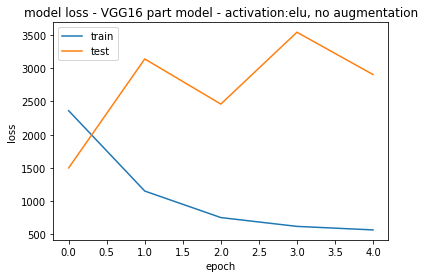

In [97]:
# Vanilla training
results = model.fit(X_train_after_split, Y_train_after_split, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=numEpochs)

model_json = model.to_json()
with open("model_kp_no_aug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_kp_weights_no_aug.h5")
print("Saved model to disk")

with open('partVGGNoAug', 'wb') as file_pi:
    pickle.dump(results.history, file_pi)
        
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss - VGG16 part model - activation:elu, no augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 680 samples, validate on 60 samples
Epoch 1/5
680/680 [==============================] - 220s 324ms/step - loss: 680.1249 - mean_squared_error: 680.1249 - val_loss: 3507.3726 - val_mean_squared_error: 3507.3726
Epoch 2/5
680/680 [==============================] - 221s 325ms/step - loss: 602.0858 - mean_squared_error: 602.0858 - val_loss: 3777.5971 - val_mean_squared_error: 3777.5971
Epoch 3/5
680/680 [==============================] - 221s 325ms/step - loss: 587.8103 - mean_squared_error: 587.8103 - val_loss: 4476.7771 - val_mean_squared_error: 4476.7771
Epoch 4/5
680/680 [==============================] - 222s 327ms/step - loss: 583.8234 - mean_squared_error: 583.8234 - val_loss: 5210.6461 - val_mean_squared_error: 5210.6461
Epoch 5/5
680/680 [==============================] - 223s 327ms/step - loss: 570.4571 - mean_squared_error: 570.4571 - val_loss: 6460.1352 - val_mean_squared_error: 6460.1352
Saved model to disk


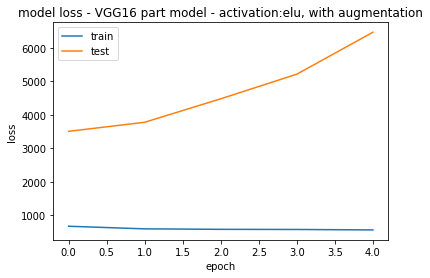

In [98]:
# Add Data Augmentation
X_train_aug_split = np.concatenate((X_train_after_split, augmented_imgs), axis=0)
Y_train_aug_split = np.concatenate((Y_train_after_split, augmented_labels), axis=0)

results = model.fit(X_train_aug_split, Y_train_aug_split, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=numEpochs)

model_json = model.to_json()
with open("model_kp_with_aug.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_kp_weights_with_aug.h5")
print("Saved model to disk")

with open('partVGGWithAug', 'wb') as file_pi:
    pickle.dump(results.history, file_pi)
        
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss - VGG16 part model - activation:elu, with augmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Keypoint 0: (112.00000000, 45.00000000) -> (15.00000000, 45.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (69.00000000, 9.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (69.00000000, 109.00000000)


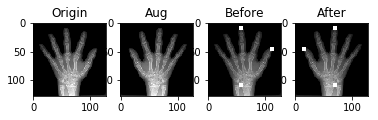

Keypoint 0: (68.00000000, 11.00000000) -> (59.00000000, 11.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (68.00000000, 99.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (15.00000000, 47.00000000)


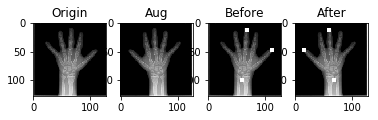

Keypoint 0: (112.00000000, 44.00000000) -> (15.00000000, 44.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (69.00000000, 6.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (71.00000000, 109.00000000)


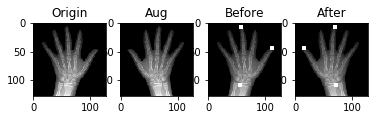

340
Keypoint 0: (112.00000000, 45.00000000) -> (114.00000000, 51.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (65.00000000, 9.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (52.00000000, 108.00000000)


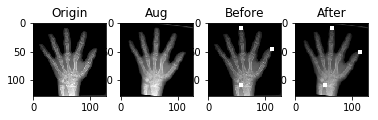

Keypoint 0: (68.00000000, 11.00000000) -> (48.00000000, 13.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (72.00000000, 98.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (102.00000000, 30.00000000)


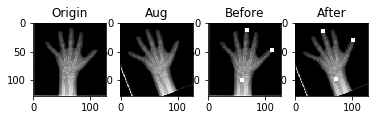

Keypoint 0: (112.00000000, 44.00000000) -> (115.00000000, 57.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (72.00000000, 6.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (45.00000000, 106.00000000)


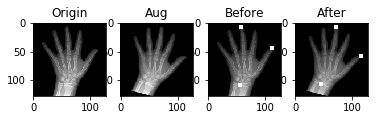

340
Keypoint 0: (112.00000000, 45.00000000) -> (115.00000000, 48.00000000)
Keypoint 1: (58.00000000, 9.00000000) -> (61.00000000, 12.00000000)
Keypoint 2: (58.00000000, 109.00000000) -> (61.00000000, 112.00000000)


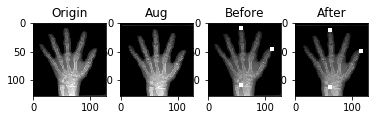

Keypoint 0: (68.00000000, 11.00000000) -> (81.00000000, 25.00000000)
Keypoint 1: (59.00000000, 99.00000000) -> (72.00000000, 113.00000000)
Keypoint 2: (112.00000000, 47.00000000) -> (125.00000000, 61.00000000)


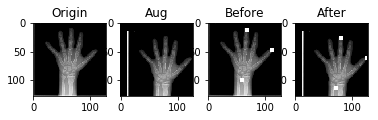

Keypoint 0: (112.00000000, 44.00000000) -> (125.00000000, 38.00000000)
Keypoint 1: (58.00000000, 6.00000000) -> (71.00000000, 0.00000000)
Keypoint 2: (56.00000000, 109.00000000) -> (69.00000000, 103.00000000)


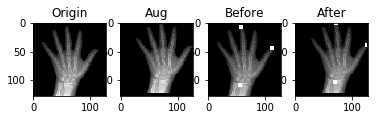

340


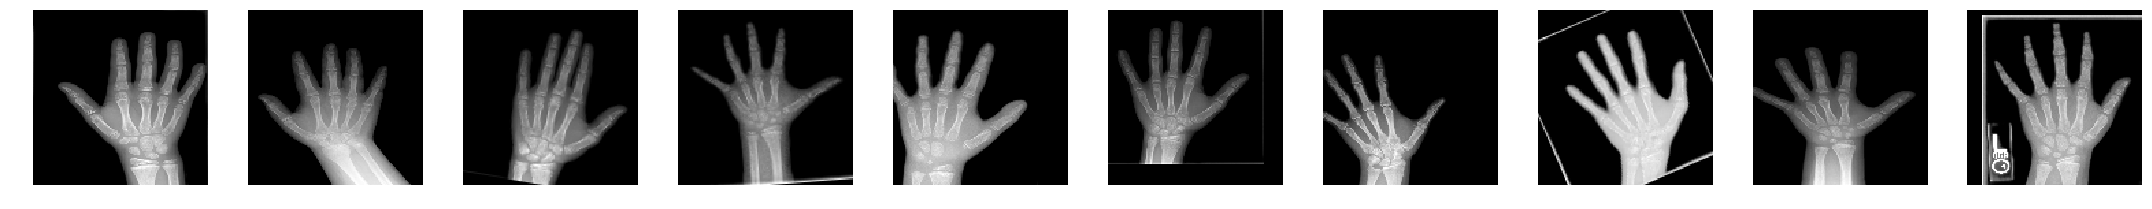

Train on 1360 samples, validate on 60 samples
Epoch 1/5
1360/1360 [==============================] - 442s 325ms/step - loss: 615.4889 - mean_squared_error: 615.4889 - val_loss: 5460.3310 - val_mean_squared_error: 5460.3310
Epoch 2/5
1360/1360 [==============================] - 441s 324ms/step - loss: 570.2662 - mean_squared_error: 570.2662 - val_loss: 4464.4842 - val_mean_squared_error: 4464.4842
Epoch 3/5
1360/1360 [==============================] - 442s 325ms/step - loss: 572.0626 - mean_squared_error: 572.0626 - val_loss: 6131.2058 - val_mean_squared_error: 6131.2058
Epoch 4/5
1360/1360 [==============================] - 443s 325ms/step - loss: 561.5694 - mean_squared_error: 561.5694 - val_loss: 6216.9735 - val_mean_squared_error: 6216.9735
Epoch 5/5
1360/1360 [==============================] - 447s 329ms/step - loss: 547.7922 - mean_squared_error: 547.7922 - val_loss: 6018.7678 - val_mean_squared_error: 6018.7678
Saved model to disk


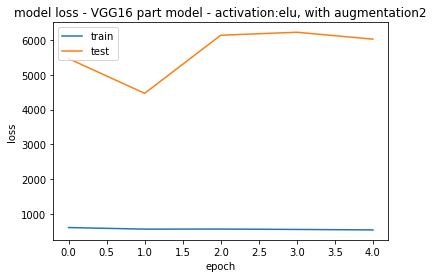

In [99]:
# Data Augmentation #2
ia.seed(1)
trainSize = len(X_train_after_split)
border = 3

seqFlip = iaa.Sequential(
[            
    iaa.Fliplr(1.0)    
], random_order=True)

seqRot = iaa.Sequential(
[    
    iaa.Affine( rotate=(-30, 30), deterministic=True)    
], random_order=True)
seqTrans = iaa.Sequential(
[    
    iaa.Affine( translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)}, deterministic=True),    
], random_order=True)

seqList = [seqFlip, seqRot, seqTrans]

augmented_imgs_total = np.zeros((len(seqList) * trainSize, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
augmented_labels_total = np.zeros((len(seqList) * trainSize, 6), dtype=np.float32)

def createAugmentation(seq, originalImages=X_train_after_split, originalKeyPoints=Y_train_after_split):
    augmented_imgs = np.zeros((len(originalImages), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
    augmented_labels = np.zeros((len(originalKeyPoints), 6), dtype=np.float32)
    k = 0
    for n, annotate_img_ in enumerate (originalImages):
        bSkip = True
        try:            
            while bSkip == True:            
                current_img = X_train_after_split[n]
                keypoints = ia.KeypointsOnImage([
                ia.Keypoint(x=int(Y_train_after_split[n][0]), y=int(Y_train_after_split[n][1])),
                ia.Keypoint(x=int(Y_train_after_split[n][2]), y=int(Y_train_after_split[n][3])),
                ia.Keypoint(x=int(Y_train_after_split[n][4]), y=int(Y_train_after_split[n][5]))
                ], shape=current_img.shape)

                seq_det = seq.to_deterministic()            
                image_aug = seq_det.augment_images([current_img])[0]
                keypoints_aug = seq_det.augment_keypoints([keypoints])[0]            
                bSkip = False
                if np.equal(keypoints, keypoints_aug):
                    bSkip = True
                for j in range(3):
                    if keypoints_aug.keypoints[j].x > (IMG_WIDTH-border) or keypoints_aug.keypoints[j].y > (IMG_HEIGHT-border):
                        bSkip = True
                    if keypoints_aug.keypoints[j].x < 0 or keypoints_aug.keypoints[j].y < 0:
                        bSkip = True

            augmented_imgs[k,:,:,:] = image_aug    
            augmented_labels[k,0] = keypoints_aug.keypoints[0].x
            augmented_labels[k,1] = keypoints_aug.keypoints[0].y
            augmented_labels[k,2] = keypoints_aug.keypoints[1].x
            augmented_labels[k,3] = keypoints_aug.keypoints[1].y
            augmented_labels[k,4] = keypoints_aug.keypoints[2].x
            augmented_labels[k,5] = keypoints_aug.keypoints[2].y
            k+=1
            if k % 100 == 0:
                for i in range(len(keypoints.keypoints)):
                    before = keypoints.keypoints[i]
                    after = keypoints_aug.keypoints[i]
                    print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
                        i, before.x, before.y, after.x, after.y)
                    )

                # image with keypoints before/after augmentation (shown below)
                image_before = keypoints.draw_on_image(current_img,color=1.0, size=7)
                image_after = keypoints_aug.draw_on_image(image_aug,color=1.0, size=7)

                plt.subplot(141),plt.imshow(current_img[:,:,0], cmap='gray'),plt.title('Origin')
                plt.subplot(142),plt.imshow(image_aug[:,:,0], cmap='gray'),plt.title('Aug')
                plt.subplot(143),plt.imshow(image_before[:,:,0], cmap='gray'),plt.title('Before')
                plt.subplot(144),plt.imshow(image_after[:,:,0], cmap='gray'),plt.title('After')
                plt.show()

        except:         
            print("error")

    print(k)
    return augmented_imgs, augmented_labels


augmented_imgs_total[:trainSize,:,:,:], augmented_labels_total[:trainSize] = createAugmentation(seqFlip, X_train_after_split, Y_train_after_split)
augmented_imgs_total[trainSize:2*trainSize,:,:,:], augmented_labels_total[trainSize:2*trainSize] = createAugmentation(seqRot, X_train_after_split, Y_train_after_split)
augmented_imgs_total[2*trainSize:3*trainSize,:,:,:], augmented_labels_total[2*trainSize:3*trainSize] = createAugmentation(seqTrans, X_train_after_split, Y_train_after_split)

img_utils.showRandomDataFromArray(augmented_imgs_total)
# # Add Data Augmentation
X_train_aug2_split = np.concatenate((X_train_after_split, augmented_imgs_total), axis=0)
Y_train_aug2_split = np.concatenate((Y_train_after_split, augmented_labels_total), axis=0)

results = model.fit(X_train_aug2_split, Y_train_aug2_split, validation_data=(X_val, Y_val), 
                    batch_size=batchSize, epochs=numEpochs)

model_json = model.to_json()
with open("model_kp_with_aug2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_kp_weights_with_aug2.h5")
print("Saved model to disk")

with open('partVGGWithAug2', 'wb') as file_pi:
    pickle.dump(results.history, file_pi)
        
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss - VGG16 part model - activation:elu, with augmentation2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(1020, 128, 128, 1)
(1020, 6)
(180, 128, 128, 1)
(180, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         1735488   
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 49158     
Total params: 1,784,646
Trainable params: 49,158
Non-trainable params: 1,735,488
_________________________________________________________________
Train on 1020 samples, validate on 180 samples
Epoch 1/5
1020/1020 [==============================] - 352s 345ms/step - loss: 479.6326 - mean_squared_error: 479.6326 - val_loss: 6702.5450 - val_mean_sq

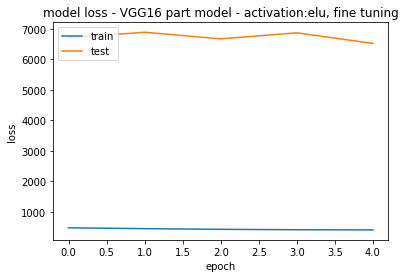

In [100]:
# Fine Tuning of VGG16 with ImageNet weights
from keras.applications import VGG16

X_trainVGG = np.tile(X_train_after_split, (3,1,1,1))
Y_trainVGG = np.tile(Y_train_after_split, (3,1))
X_valVGG = np.tile(X_val, (3,1,1,1))
Y_valVGG = np.tile(Y_val, (3,1))

print(X_trainVGG.shape)
print(Y_trainVGG.shape)
print(X_valVGG.shape)
print(Y_valVGG.shape)

conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
conv_base.layers.pop()
conv_base.layers.pop()
conv_base.layers.pop()
conv_base.layers.pop()
conv_base.layers.pop()
conv_base.layers.pop()
conv_base.layers.pop()
conv_base.layers.pop()

conv_base.trainable = False

modelFineTuning = Sequential()
modelFineTuning.add(conv_base)
modelFineTuning.add(Flatten())
modelFineTuning.add(Dropout(0.5))
modelFineTuning.add(Dense(6))

modelFineTuning.summary()

results = model.fit(X_trainVGG, Y_trainVGG, validation_data=(X_valVGG, Y_valVGG), 
                    batch_size=batchSize, epochs=numEpochs)
model_json = model.to_json()
with open("model_kp_fine_tuning.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_kp_weights_fine_tuning.h5")
print("Saved model to disk")

with open('partVGGWFineTuning', 'wb') as file_pi:
    pickle.dump(results.history, file_pi)
        
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss - VGG16 part model - activation:elu, fine tuning')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Inference Phase + Geometric Transformation

In [ ]:
test_files = os.listdir(TEST_PATH)
test_img = os.path.join(TEST_PATH, test_files[100])
t_img = np.expand_dims(imread(fullPath)[:,:], axis=2)    
t_img = resize(t_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)    
t_img /= 255
t_img = np.expand_dims(t_img, axis=0)
pred = model.predict(t_img)

In [ ]:
refPts = np.concatenate([[110, 50], [60, 10], [0, 100]], axis=0).astype(np.float32)
refPts = refPts.reshape((3,2))

curPts = np.concatenate([[pred[0][0], pred[0][1]], [pred[0][2], pred[0][3]], [pred[0][4], pred[0][5]]], axis=0).astype(np.float32)
curPts = curPts.reshape((3,2))

M = cv2.getAffineTransform(srcPts, refPts)        
t = np.insert(srcPts, 2, 1, axis=1)
a = M.dot(t[0])
b = M.dot(t[1])
c = M.dot(t[2])
      
dst = cv2.warpAffine(img,M,(IMG_WIDTH,IMG_HEIGHT))        
plt.subplot(121),plt.imshow(img[:,:,0], cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title('Output')
plt.show()

# TODO: copy warpped imgs to files

In [ ]:
print(pred[0][0], pred[0][1])
print(pred[0][2], pred[0][3])
print(pred[0][4], pred[0][5])

plt.imshow(t_img[0,:,:,0])
plt.annotate('point #1', (pred[0][0], pred[0][1]))
plt.annotate('point #2', (pred[0][2], pred[0][3]))
plt.annotate('point #3', (pred[0][4], pred[0][5]))
plt.show()